# ISYE 6740 Final Project - omerkhan & afante3

In [170]:
import pandas as pd
import requests
import numpy as np
import nba_api.stats.endpoints as nba_stats
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.static import teams
import time
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nba_api.stats.endpoints import leaguestandings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

## Pre-processing steps needed to construct the dataset used for training.  However, you can skip ahead to model training which loads the equivalent data from a static file.

#### Using NBA Season data from 2010-2020

In [171]:
seasons = [
    '2010-11',
    '2011-12',
    '2012-13',
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2019-20'
]

#### Leveraging the NBA API, we can build a dataset of player and team information over our season period and calculate per game averages for each season and player across the period. The NBA_API can be viewed in further detail [here](https://github.com/swar/nba_api)

In [172]:
total_player_stats_df = pd.DataFrame()

for season in seasons:
    league_leaders = leagueleaders.LeagueLeaders(
      season=season,
      season_type_all_star="Regular Season",
      stat_category_abbreviation='PTS'
    ).get_data_frames()[0]

    league_leaders_df = league_leaders[['PLAYER_ID', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'EFF', 'AST_TOV']]
    league_leaders_df = league_leaders_df.copy()
    league_leaders_df.loc[:, 'PPG'] = league_leaders_df['PTS'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'RPG'] = league_leaders_df['REB'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'APG'] = league_leaders_df['AST'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'SPG'] = league_leaders_df['STL'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'BPG'] = league_leaders_df['BLK'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'TPG'] = league_leaders_df['TOV'] / league_leaders_df['GP']
    league_leaders_df['YEAR'] = season

    league_leaders_pg_df = league_leaders_df[['YEAR', 'PLAYER_ID', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'EFF', 'AST_TOV', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG']]

    total_player_stats_df = pd.concat([total_player_stats_df, league_leaders_pg_df], sort=False)


KeyboardInterrupt: 

In [ ]:
total_player_stats_df

##### Given our goal to try to predict the All-NBA selections, we need to be cognizant of the positional limitations that have typically occurred during voting, historically, Basketball is played with 5 major positions. Point Guard, Shooting Guard, Small Forward, Power Forward, and Center. Given these limitations we want to add the notion of position to our dataset to ensure that we can do some post processing considerations later.

In [ ]:
def get_player_position(player_id):
  try:
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
    player_info_dict = player_info.get_normalized_dict()
    position = player_info_dict['CommonPlayerInfo'][0]['POSITION']
    return position
  except Exception as e:
    print(f"Unable to Fetch Position {player_id}: {e}")
    return None

def assign_positions_to_df(df, player_positions):
  df['POS'] = player_positions[df['PLAYER_ID']]
  return df

##### Given many players play across multiple years, we need to further filter this to unique player ids:

In [ ]:
unique_player_ids = total_player_stats_df['PLAYER_ID'].unique()

In [ ]:
player_pos = {}
for player_id in unique_player_ids:
    try:
        position = get_player_position(player_id)
        player_pos[player_id] = position
        print(f"Identified Player ID {player_id}, Position: {position}")
    except Exception as e:
        print(f"Error with Player ID {player_id}: {e}")
    time.sleep(1)


In [ ]:
def get_position(player_id):
  try:
    position = get_player_position(player_id)
    return player_id, position
  except Exception as e:
    print(f"Error with Player ID {player_id}: {e}")
    return player_id, None

player_pos = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
  futures = {executor.submit(get_position, player_id): player_id for player_id in unique_player_ids}
  for future in concurrent.futures.as_completed(futures):
    player_id, position = future.result()
    if position is not None:
        player_pos[player_id] = position
        print(f"Identified Player ID {player_id}, Position: {position}")
    time.sleep(1)

##### We manually have built a dictionary containing the previous 10 years of All-NBA player selections ignoring the 3 different levels (1st, 2nd, 3rd team) and consolidating these selections across seasons.

In [ ]:
all_nba_selections = {
    "2010-11": ["Kevin Durant", "Pau Gasol", "LaMarcus Aldridge", "LeBron James", "Dirk Nowitzki", "Zach Randolph", "Dwight Howard", "Amar'e Stoudemire", "Al Horford", "Kobe Bryant", "Dwyane Wade", "Manu Ginóbili", "Derrick Rose", "Russell Westbrook", "Chris Paul"],
    "2011-12": ["LeBron James", "Kevin Love", "Carmelo Anthony", "Kevin Durant", "Blake Griffin", "Dirk Nowitzki", "Dwight Howard", "Andrew Bynum", "Tyson Chandler", "Kobe Bryant", "Tony Parker", "Dwyane Wade", "Chris Paul", "Russell Westbrook", "Rajon Rondo"],
    "2012-13": ["LeBron James", "Carmelo Anthony", "David Lee", "Kevin Durant", "Blake Griffin", "Paul George", "Tim Duncan", "Marc Gasol", "Dwight Howard", "Kobe Bryant", "Tony Parker", "Dwyane Wade", "Chris Paul", "Russell Westbrook", "James Harden"],
    "2013-14": ["Kevin Durant", "Blake Griffin", "Paul George", "LeBron James", "Kevin Love", "LaMarcus Aldridge", "Joakim Noah", "Dwight Howard", "Al Jefferson", "James Harden", "Stephen Curry", "Goran Dragić", "Chris Paul", "Tony Parker", "Damian Lillard"],
    "2014-15": ["LeBron James", "LaMarcus Aldridge", "Blake Griffin", "Anthony Davis", "Pau Gasol", "Tim Duncan", "Marc Gasol", "DeMarcus Cousins", "DeAndre Jordan", "James Harden", "Russell Westbrook", "Klay Thompson", "Stephen Curry", "Chris Paul", "Kyrie Irving"],
    "2015-16": ["Kawhi Leonard", "Kevin Durant", "Paul George", "LeBron James", "Draymond Green", "LaMarcus Aldridge", "DeAndre Jordan", "DeMarcus Cousins", "Andre Drummond", "Stephen Curry", "Damian Lillard", "Klay Thompson", "Russell Westbrook", "Chris Paul", "Kyle Lowry"],
    "2016-17": ["Kawhi Leonard", "Kevin Durant", "Jimmy Butler", "LeBron James", "Giannis Antetokounmpo", "Draymond Green", "Anthony Davis", "Rudy Gobert", "DeAndre Jordan", "James Harden", "Stephen Curry", "John Wall", "Russell Westbrook", "Isaiah Thomas", "DeMar DeRozan"],
    "2017-18": ["Kevin Durant", "LaMarcus Aldridge", "Jimmy Butler", "LeBron James", "Giannis Antetokounmpo", "Paul George", "Anthony Davis", "Joel Embiid", "Karl-Anthony Towns", "James Harden", "DeMar DeRozan", "Victor Oladipo", "Damian Lillard", "Russell Westbrook", "Stephen Curry"],
    "2018-19": ["Giannis Antetokounmpo", "Kevin Durant", "Blake Griffin", "Paul George", "Kawhi Leonard", "LeBron James", "Nikola Jokić", "Joel Embiid", "Rudy Gobert", "James Harden", "Damian Lillard", "Russell Westbrook", "Stephen Curry", "Kyrie Irving", "Kemba Walker"],
    "2019-20": ["LeBron James", "Kawhi Leonard", "Jimmy Butler", "Giannis Antetokounmpo", "Pascal Siakam", "Jayson Tatum", "Anthony Davis", "Nikola Jokić", "Rudy Gobert", "James Harden", "Damian Lillard", "Ben Simmons", "Luka Dončić", "Chris Paul", "Russell Westbrook"]
}


##### We need a binary classifier to determine whether a player was selected as All-NBA across the season in question, the below helper and lambda function allow us to also add this classification to our dataset.

In [ ]:
def assign_all_nba_status(df, all_nba_dict):
  def is_all_nba(player, year):
      return player in all_nba_dict.get(year, [])
  df['is_all_nba'] = df.apply(lambda row: is_all_nba(row['PLAYER'], row['YEAR']), axis=1)
  return df

total_player_w_all_nba_df =  assign_all_nba_status(total_player_stats_df, all_nba_selections)

##### Similarly, we can use our previously defined player dictionary to assign positions to the players:

In [ ]:
def assign_pos(df, player_pos):
  def get_pos(player_id):
      return position in player_pos.get(player_id, "")
  df['POSITION'] = df.apply(lambda row: player_pos[row['PLAYER_ID']], axis=1)
  return df

In [ ]:
total_player_w_pos_nba_df =  assign_pos(total_player_w_all_nba_df, player_pos)

In [ ]:
total_player_w_pos_nba_df.to_csv('full_player_data_10-20.csv', index=False)

#### Alternatively, you can use the static, pre-constructed dataset with position loaded so you don't need to wait for the labeling to run above.

In [3]:
total_player_w_pos_nba_df = pd.read_csv("data/full_player_data_10-20.csv")
total_player_w_pos_nba_df['season_start_year'] = total_player_w_pos_nba_df['YEAR'].apply(lambda x: int(x.split('-')[0]))
total_player_w_pos_nba_df

,YEAR,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,FG_PCT,FG3_PCT,FT_PCT,EFF,AST_TOV,PPG,RPG,APG,SPG,BPG,TPG,is_all_nba,POSITION,season_start_year
0,2010-11,201142,Kevin Durant,1610612760,OKC,78,0.462,0.350,0.880,1946,0.98,27.705128,6.833333,2.743590,1.128205,0.974359,2.794872,True,Forward,2010
1,2010-11,2544,LeBron James,1610612748,MIA,79,0.510,0.330,0.759,2258,1.95,26.721519,7.468354,7.012658,1.569620,0.632911,3.594937,True,Forward,2010
2,2010-11,977,Kobe Bryant,1610612747,LAL,82,0.451,0.323,0.828,1754,1.60,25.341463,5.109756,4.731707,1.207317,0.146341,2.963415,True,Forward-Guard,2010
3,2010-11,201565,Derrick Rose,1610612741,CHI,81,0.445,0.332,0.858,1872,2.24,25.012346,4.074074,7.691358,1.049383,0.629630,3.432099,True,Guard,2010
4,2010-11,2405,Amar'e Stoudemire,1610612752,NYK,78,0.502,0.435,0.792,1918,0.81,25.269231,8.153846,2.589744,0.910256,1.923077,3.205128,True,Forward-Center,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,2019-20,1629676,Isaiah Roby,1610612760,OKC,3,0.000,0.000,0.000,0,0.00,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,False,Forward,2019
4929,2019-20,1629122,J.P. Macura,1610612739,CLE,1,0.000,0.000,0.000,0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,Guard,2019
4930,2019-20,1629716,Marques Bolden,1610612739,CLE,1,0.000,0.000,0.000,3,0.00,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,False,Center,2019
4931,2019-20,1629742,Stanton Kidd,1610612762,UTA,4,0.000,0.000,0.000,-1,0.50,0.000000,0.750000,0.250000,0.000000,0.000000,0.500000,False,Forward,2019


In [141]:
def fetch_season_data(season):
    standings = leaguestandings.LeagueStandings(season=season)
    return standings.get_data_frames()[0]

all_seasons_data = pd.concat([fetch_season_data(season) for season in seasons])
all_seasons_data['Start_Year'] = all_seasons_data['SeasonID'].str[1:]
team_winning_df = all_seasons_data[['WinPCT', 'Start_Year', 'TeamID']]
team_winning_df['Start_Year']  = team_winning_df['Start_Year'].astype(int)

/var/folders/tt/_0j7v6r90_s6mr6y9p1hv1lw0000gn/T/ipykernel_11593/3922218746.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_winning_df['Start_Year']  = team_winning_df['Start_Year'].astype(int)


In [144]:
final_df = total_player_w_pos_nba_df.merge(team_winning_df, left_on=['TEAM_ID','season_start_year'], right_on=['TeamID','Start_Year'], how='inner')
final_df

,YEAR,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,FG_PCT,FG3_PCT,FT_PCT,EFF,...,APG,SPG,BPG,TPG,is_all_nba,POSITION,season_start_year,WinPCT,Start_Year,TeamID
0,2010-11,201142,Kevin Durant,1610612760,OKC,78,0.462,0.350,0.880,1946,...,2.743590,1.128205,0.974359,2.794872,True,Forward,2010,0.671,2010,1610612760
1,2010-11,201566,Russell Westbrook,1610612760,OKC,82,0.442,0.330,0.842,1835,...,8.170732,1.890244,0.365854,3.853659,True,Guard,2010,0.671,2010,1610612760
2,2010-11,201935,James Harden,1610612760,OKC,82,0.436,0.349,0.843,999,...,2.146341,1.121951,0.292683,1.292683,False,Guard,2010,0.671,2010,1610612760
3,2010-11,201586,Serge Ibaka,1610612760,OKC,82,0.543,0.000,0.750,1282,...,0.268293,0.378049,2.414634,0.865854,False,Forward,2010,0.671,2010,1610612760
4,2010-11,1737,Nazr Mohammed,1610612760,OKC,75,0.522,0.000,0.598,683,...,0.306667,0.400000,0.746667,0.933333,False,Center,2010,0.671,2010,1610612760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,2019-20,1628476,Derrick Walton Jr.,1610612765,DET,26,0.462,0.417,0.778,75,...,1.038462,0.269231,0.000000,0.192308,False,Guard,2019,0.303,2019,1610612765
4929,2019-20,1629663,Louis King,1610612765,DET,10,0.381,0.364,0.000,19,...,0.500000,0.200000,0.000000,0.200000,False,Forward,2019,0.303,2019,1610612765
4930,2019-20,1629017,Khyri Thomas,1610612765,DET,8,0.294,0.357,0.500,7,...,0.375000,0.375000,0.000000,0.375000,False,Guard,2019,0.303,2019,1610612765
4931,2019-20,1629648,Jordan Bone,1610612765,DET,10,0.250,0.200,0.000,8,...,0.800000,0.100000,0.000000,0.200000,False,Guard,2019,0.303,2019,1610612765


In [169]:
final_df.to_csv('2010-2020_final_df.csv', index=False)

## Start here to use pre-constructed dataset and go into model experimentation.

In [173]:
final_df = pd.read_csv('data/2010-2020_final_df.csv')

In [174]:

features = ['GP', 'PPG', 'RPG', 'APG', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'SPG', 'BPG', 'TPG',  'is_all_nba', 'WinPCT']
X = final_df[features].drop('is_all_nba', axis=1)
y = final_df['is_all_nba']

train_df = final_df[final_df['season_start_year'] < 2017]
test_df = final_df[final_df['season_start_year'] >= 2017]

X_train = train_df[features].drop('is_all_nba', axis=1)
y_train = train_df['is_all_nba']
X_test = test_df[features].drop('is_all_nba', axis=1)
y_test = test_df['is_all_nba']

## BINARY CLASSIFICATION

##### Taking our more complete data frame, we can do a few additional pre-processing steps before using a RandomForestClassifier. As one can see in the code below, splitting the data into sections before and after 2017, and using is_all_nba as our feature for our training variable, before initializing and fitting our Random Forest.

In [175]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

       False       0.99      1.00      1.00      1557
        True       0.85      0.79      0.81        42

    accuracy                           0.99      1599
   macro avg       0.92      0.89      0.91      1599
weighted avg       0.99      0.99      0.99      1599



##### We can now sort our features and plot them to give us visual reference for the importance of each

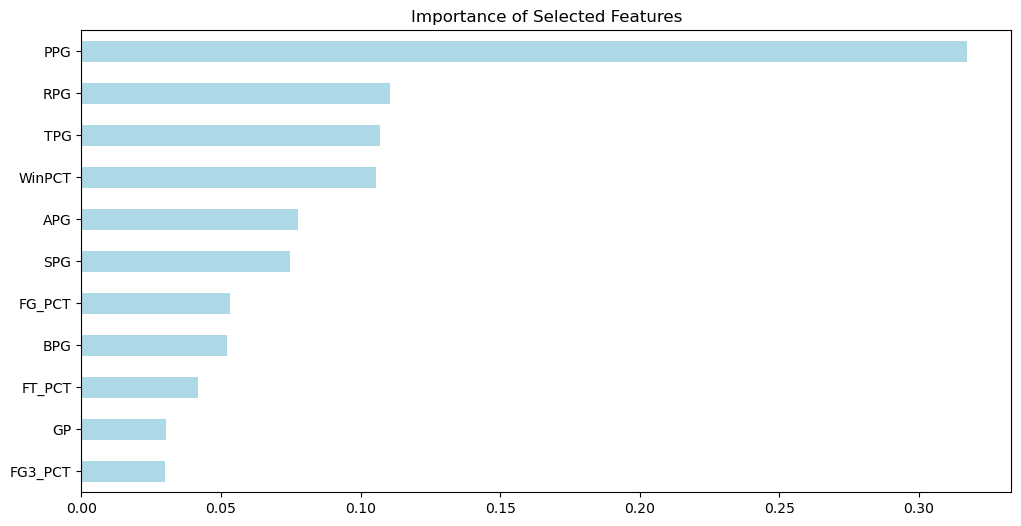

In [176]:
feature_importances = model.feature_importances_
features = X_train.columns
importances = pd.Series(feature_importances, index=features)
importances_sorted = importances.sort_values()

plt.figure(figsize=(12,6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Importance of Selected Features')
plt.show()


In [177]:
importances


GP         0.030313
PPG        0.317135
RPG        0.110644
APG        0.077559
FG_PCT     0.053113
FG3_PCT    0.030029
FT_PCT     0.041823
SPG        0.074612
BPG        0.052288
TPG        0.106884
WinPCT     0.105598
dtype: float64

## Gradient Boost Classification

In [178]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
print(classification_report(y_test, gb_predictions))


              precision    recall  f1-score   support

       False       1.00      0.99      0.99      1557
        True       0.69      0.83      0.75        42

    accuracy                           0.99      1599
   macro avg       0.84      0.91      0.87      1599
weighted avg       0.99      0.99      0.99      1599



In [179]:
results_df = pd.DataFrame({
    'Player': test_df['PLAYER'],
    'Year': test_df['YEAR'],
    'Actual': y_test,
    'Predicted': gb_predictions
})

results_df['Comparison'] = results_df['Actual'] == results_df['Predicted']
mismatched_results = results_df[results_df['Comparison'] == False]
print(mismatched_results.drop_duplicates())


                  Player     Year  Actual  Predicted  Comparison
3373    DeMarcus Cousins  2017-18   False       True       False
3525        Jimmy Butler  2017-18    True      False       False
3593        Kyrie Irving  2017-18   False       True       False
3652        Nikola Jokic  2017-18   False       True       False
3875        Clint Capela  2018-19   False       True       False
3911        Kemba Walker  2018-19    True      False       False
3965       Klay Thompson  2018-19   False       True       False
3998  Karl-Anthony Towns  2018-19   False       True       False
4016       Blake Griffin  2018-19    True      False       False
4033    Donovan Mitchell  2018-19   False       True       False
4069   LaMarcus Aldridge  2018-19   False       True       False
4152        Nikola Jokic  2018-19   False       True       False
4205       Anthony Davis  2018-19   False       True       False
4424      Damian Lillard  2019-20    True      False       False
4491         Luka Doncic 

In [185]:
X_test_with_player = test_df[['PLAYER']].copy()
X_test_with_player['Actual'] = y_test
X_test_with_player['Predicted'] = gb_predictions
print(X_test_with_player[X_test_with_player['Actual'] != X_test_with_player['Predicted']].drop_duplicates())


                  PLAYER  Actual  Predicted
3373    DeMarcus Cousins   False       True
3525        Jimmy Butler    True      False
3593        Kyrie Irving   False       True
3652        Nikola Jokic   False       True
3875        Clint Capela   False       True
3911        Kemba Walker    True      False
3965       Klay Thompson   False       True
3998  Karl-Anthony Towns   False       True
4016       Blake Griffin    True      False
4033    Donovan Mitchell   False       True
4069   LaMarcus Aldridge   False       True
4205       Anthony Davis   False       True
4424      Damian Lillard    True      False
4491         Luka Doncic   False       True
4587         Paul George   False       True
4669         Joel Embiid   False       True
4671         Ben Simmons    True      False
4740          Chris Paul    True      False
4757    Domantas Sabonis   False       True


## Random Forest with Probabilities

In [188]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
prob_predictions = model.predict_proba(X_test)
positive_class_probs = prob_predictions[:, 1]
results_df = pd.DataFrame({
    'Player': test_df['PLAYER'],
    'Player_ID': test_df['PLAYER_ID'],
    'Position': test_df['POSITION'],
    'Year': test_df['YEAR'],
    'Actual': y_test,
    'Predicted Probability': positive_class_probs
})
predicted_probabilities_df = results_df.sort_values(by=['Year', 'Predicted Probability'], ascending=False)

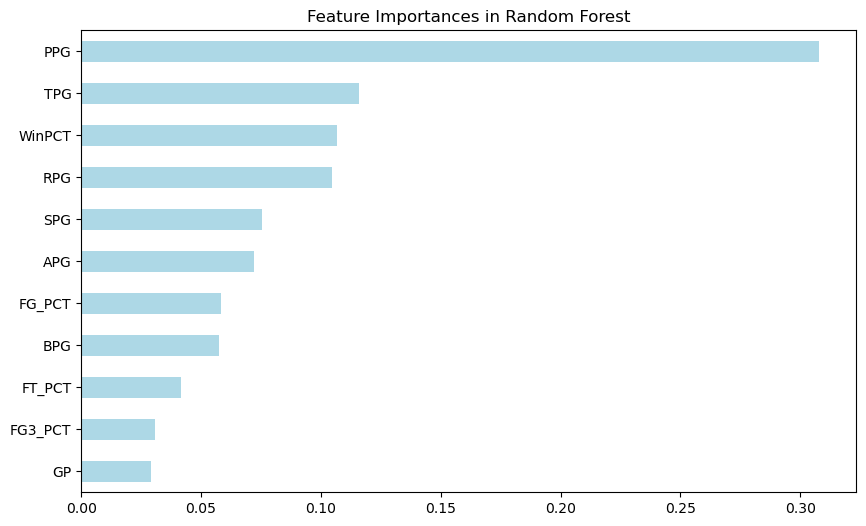

In [189]:
feature_importances = model.feature_importances_
features = X_train.columns

importances = pd.Series(feature_importances, index=features)


importances_sorted = importances.sort_values()

# Plot
plt.figure(figsize=(10,6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Feature Importances in Random Forest')
plt.show()


We would've expected points and win percentage to play a critical part in All-NBA selections.  However, TPG is quite surprising as it's typically viewed as a negative.  We suspect that the model is rewarding high turnovers because its a sign of high usage, which the best players in basketball typically will have.

In [156]:

predicted_probabilities_df['Predicted_AllNBA'] = False

# Define a function to mark top players
def mark_top_players(group):
    for position in ['Guard', 'Forward', 'Center']:
        # Define the number of players to select for each position
        num_to_select = 6 if position in ['Guard', 'Forward'] else 3
        top_players = group[group['Position'].str.contains(position)].nlargest(num_to_select, 'Predicted Probability')
        group.loc[top_players.index, 'Predicted_AllNBA'] = True
    return group

# Group by year and apply the function
predicted_probabilities_df = predicted_probabilities_df.groupby('Year', group_keys=True).apply(mark_top_players)

In [157]:
predicted_probabilities_df['Comparison'] = predicted_probabilities_df.apply(lambda x: 'Match' if (x['Actual'] == 1 and x['Predicted_AllNBA'] == 1) or (x['Actual'] == 0 and x['Predicted_AllNBA'] == 0 ) else 'Mismatch', axis=1)

In [ ]:
predicted_probabilities_df[predicted_probabilities_df['Predicted_AllNBA'] == True]

In [ ]:
mismatched_players_df = predicted_probabilities_df[predicted_probabilities_df['Comparison'] == 'Mismatch' ]
mismatched_players_df[mismatched_players_df['Predicted_AllNBA'] == False]

In [159]:
print(classification_report(predicted_probabilities_df['Actual'], predicted_probabilities_df['Predicted_AllNBA']))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1557
        True       0.76      0.69      0.72        42

    accuracy                           0.99      1599
   macro avg       0.88      0.84      0.86      1599
weighted avg       0.99      0.99      0.99      1599



## Multiple Regression

In [164]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Predict probabilities on the test data
# The output will have two columns: [probability of class 0, probability of class 1]
prob_predictions = log_reg.predict_proba(X_test)

# Extracting the probabilities for the positive class (class 1)
positive_class_probs = prob_predictions[:, 1]

# If you want to create a DataFrame with the results
results_df = pd.DataFrame({
    'Player': test_df['PLAYER'],
    'Player_ID': test_df['PLAYER_ID'],
    'Position': test_df['POSITION'],
    'Year': test_df['YEAR'],
    'Actual': y_test,
    'Predicted Probability': positive_class_probs
})

regression_predicted_probabilities_df = results_df.sort_values(by=['Year', 'Predicted Probability'], ascending=False)
regression_predicted_probabilities_df

/Users/omerkhan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Player,Player_ID,Position,Year,Actual,Predicted Probability
4457,Giannis Antetokounmpo,203507,Forward,2019-20,True,9.987642e-01
4530,LeBron James,2544,Forward,2019-20,True,9.926573e-01
4404,James Harden,201935,Guard,2019-20,True,9.923459e-01
4491,Luka Doncic,1629029,Forward-Guard,2019-20,False,9.888136e-01
4531,Anthony Davis,203076,Forward-Center,2019-20,True,9.426206e-01
...,...,...,...,...,...,...
3521,Marcus Paige,1627779,Guard,2017-18,False,7.959208e-07
3855,Adreian Payne,203940,Forward,2017-18,False,3.971349e-07
3723,Antonius Cleveland,1628499,Guard,2017-18,False,3.282578e-07
3587,David Stockton,204065,Guard,2017-18,False,2.973160e-07


In [165]:
regression_predicted_probabilities_df['Predicted_AllNBA'] = False
regression_predicted_probabilities_df = regression_predicted_probabilities_df.groupby('Year', group_keys=True).apply(mark_top_players)

In [166]:
regression_predicted_probabilities_df

Player  Player_ID        Position     Year  \
Year                                                                      
2017-18 3334           LeBron James       2544         Forward  2017-18   
        3351           James Harden     201935           Guard  2017-18   
        3390      Russell Westbrook     201566           Guard  2017-18   
        3371          Anthony Davis     203076  Forward-Center  2017-18   
        3407  Giannis Antetokounmpo     203507         Forward  2017-18   
...                             ...        ...             ...      ...   
2019-20 4896            Joe Chealey    1629147           Guard  2019-20   
        4489      Charlie Brown Jr.    1629718           Guard  2019-20   
        4863       Zach Norvell Jr.    1629668   Guard-Forward  2019-20   
        4735           Malik Newman    1629005           Guard  2019-20   
        4913      Jarred Vanderbilt    1629020         Forward  2019-20   

              Actual  Predicted Probability  Predicted_AllNBA  
Year                                                           
2017-18 3334    True           9.915536e-01              True  
        3351    True           9.903905e-01              True  
        3390    True           9.900903e-01              True  
        3371    True           9.754689e-01              True  
        3407    True           9.581065e-01              True  
...              ...                    ...               ...  
2019-20 4896   False           2.297693e-07             False  
        4489   False           1.886799e-07             False  
        4863   False           1.658050e-07             False  
        4735   False           1.365939e-07             False  
        4913   False           1.158467e-07             False  

[1599 rows x 7 columns]

In [167]:
print(classification_report(regression_predicted_probabilities_df['Actual'], regression_predicted_probabilities_df['Predicted_AllNBA']))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1557
        True       0.68      0.62      0.65        42

    accuracy                           0.98      1599
   macro avg       0.84      0.81      0.82      1599
weighted avg       0.98      0.98      0.98      1599

